In [1]:
import os
import copy
import cogdl
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cogdl import experiment
from cogdl.utils import set_random_seed
import gsim
import utils

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Load Dataset

In [2]:
from cogdl.datasets import build_dataset_from_path

data_path = "/home/stanislas/dataset/"
dataset_name = "cora"
dataset = build_dataset_from_path(data_path=data_path, dataset=dataset_name)
train_nid = dataset.data.train_nid
val_nid = dataset.data.val_nid
test_nid = dataset.data.test_nid

checkpoint_dir = "./checkpoints/{}".format(dataset_name)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
figure_dir = "./figures/{}".format("exp_0120_{}".format(dataset_name))
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

## Build model

In [4]:
models_dict = {}
if dataset_name in ['ogbn-arxiv']:
    hidden_size = 256
else:
    hidden_size = 64
num_layers = 2
order = 2
dropout = 0.5
seed = 0
residual = False
remove_self_loop = False
set_random_seed(seed)

In [5]:
from custom_models.mlp import MLP

if residual:
    model_name = "model_mlp_res_{}_{}_seed_{}".format(hidden_size, num_layers, seed)
else:
    model_name = "model_mlp_{}_{}_seed_{}".format(hidden_size, num_layers, seed)
checkpoint_path = os.path.join(checkpoint_dir, model_name)

model = MLP(in_feats=dataset.num_features, 
            hidden_size=hidden_size,
            out_feats=dataset.num_classes,
            num_layers=num_layers,
            dropout=dropout)
models_dict['mlp'] = {'name': model_name,
                    'model': model,
                    'path': checkpoint_path}

In [6]:
from custom_models.gcn import GCN

if residual:
    model_name = "model_gcn_res_{}_{}_seed_{}".format(hidden_size, num_layers, seed)
else:
    model_name = "model_gcn_{}_{}_seed_{}".format(hidden_size, num_layers, seed)
checkpoint_path = os.path.join(checkpoint_dir, "{}.pt".format(model_name))

model = GCN(in_feats=dataset.num_features, 
            hidden_size=hidden_size,
            out_feats=dataset.num_classes,
            num_layers=num_layers,
            residual=residual,
            dropout=dropout,
            remove_self_loop=remove_self_loop)
models_dict['gcn'] = {'name': model_name,
                    'model': model,
                    'path': checkpoint_path}

In [7]:
from custom_models.sgc import SGC

model_name = "model_sgc_{}_{}_k_{}_seed_{}".format(hidden_size, num_layers, order, seed)
checkpoint_path = os.path.join(checkpoint_dir, "{}.pt".format(model_name))

model = SGC(in_feats=dataset.num_features, 
              hidden_size=hidden_size,
              out_feats=dataset.num_classes,
              num_layers=num_layers,
              order=order,
              dropout=dropout,
              remove_self_loop=remove_self_loop)
models_dict['sgc'] = {'name': model_name,
                    'model': model,
                    'path': checkpoint_path}

In [8]:
from custom_models.appnp import APPNP

model_name = "model_sgc_{}_{}_k_{}_seed_{}".format(hidden_size, num_layers, order, seed)
checkpoint_path = os.path.join(checkpoint_dir, "{}.pt".format(model_name))

model = SGC(in_feats=dataset.num_features, 
              hidden_size=hidden_size,
              out_feats=dataset.num_classes,
              num_layers=num_layers,
              order=order,
              dropout=dropout,
              remove_self_loop=remove_self_loop)
models_dict['sgc'] = {'name': model_name,
                    'model': model,
                    'path': checkpoint_path}

### Evaluation

In [9]:
from cogdl.wrappers.model_wrapper.node_classification import NodeClfModelWrapper
from cogdl.utils import spmm

for k in models_dict.keys():
    model_wrapper = NodeClfModelWrapper(models_dict[k]['model'], None)
    model_wrapper.load_state_dict(torch.load(models_dict[k]['path']))
    model = model_wrapper.model
    model.eval()
    models_dict[k]['model'] = model

### Representation similarity

In [10]:
def get_pred_post(dataset, model, loc, n_post, prop):
    x_post = copy.deepcopy(dataset.data.x)
    graph = copy.deepcopy(dataset.data)
    graph_pred = copy.deepcopy(dataset.data)
    if remove_self_loop:
        graph.remove_self_loops()
        graph_pred.remove_self_loops()
    else:
        graph.add_remaining_self_loops()
        graph_pred.add_remaining_self_loops()
    graph.sym_norm()
    graph_pred.sym_norm()
    mid = None
    pred = None
    
    if loc == 'n':
        pred = model.embed_without_prop(graph, 2)
        return pred
    
    if loc == 'b':
        if prop:
            mid = model.embed_layer(graph, 0)
        else:
            mid = model.embed_without_prop_layer(graph, 0)
    elif loc == 'c':
        if prop:
            pred = model.embed(graph)
        else:
            pred = model.embed_without_prop(graph, num_layers)
        pred = torch.softmax(pred, dim=1)
    
    post_props = np.arange(n_post)
    for n_post_prop in post_props:
        if loc == 'a':
            graph = copy.deepcopy(dataset.data)
            if remove_self_loop:
                graph.remove_self_loops()
            else:
                graph.add_remaining_self_loops()
            graph.sym_norm()
            graph.x = x_post
            if prop:
                pred = model.embed(graph)
            else:
                pred = model.embed_without_prop(graph, num_layers)
        elif loc == 'b':
            pred = copy.deepcopy(mid.detach())
            for i in range(n_post_prop):
                pred = spmm(graph, pred)
            graph_pred.x = pred
            if prop:
                pred = model.embed_layer(graph_pred, 1)
            else:
                pred = model.embed_without_prop_layer(graph_pred, 1)
        if loc == 'a':
            x_post = spmm(graph, x_post)
        elif loc == 'b' or loc == 'c':
            pred = spmm(graph, pred)
    
    return pred

In [11]:
def get_pred(dataset, model):
    x_post = copy.deepcopy(dataset.data.x)
    graph = copy.deepcopy(dataset.data)
    pred = model.forward(graph)
    
    return pred

In [12]:
activations = {}
n_post = 5
for k in models_dict.keys():
    model = models_dict[k]['model']
    activations[k] = {}
    activations[k]['orig'] = get_pred(dataset, model)
    activations[k]['np'] = get_pred_post(dataset, model, loc='n', n_post=n_post, prop=False)
    activations[k]['a'] = get_pred_post(dataset, model, loc='a', n_post=n_post, prop=False)
    activations[k]['b'] = get_pred_post(dataset, model, loc='b', n_post=n_post, prop=False)
    activations[k]['c'] = get_pred_post(dataset, model, loc='c', n_post=n_post, prop=False)

In [13]:
rbf_threshold = 0.8
cka_values_kernel_dict = {}
locs = ['np', 'orig', 'a', 'b', 'c']
for k1 in models_dict.keys():
    n1 = len(activations[k1])
    cka_values_kernel_dict[k1] = {}
    for k2 in models_dict.keys():
        n2 = len(activations[k2])
        cka_values_kernel = np.zeros([n1, n2])
        cka_values_kernel_train = np.zeros([n1, n2])
        cka_values_kernel_val = np.zeros([n1, n2])
        cka_values_kernel_test = np.zeros([n1, n2])
        for i, l1 in enumerate(locs):
            for j, l2 in enumerate(locs):
                X = activations[k1][l1]
                Y = activations[k2][l2]
                cka_values_kernel[i][j] = gsim.cka(X, Y, mode='rbf', threshold=rbf_threshold)
                cka_values_kernel_train[i][j] = gsim.cka(X[train_nid], Y[train_nid], mode='rbf', threshold=rbf_threshold)
                cka_values_kernel_val[i][j] = gsim.cka(X[val_nid], Y[val_nid], mode='rbf', threshold=rbf_threshold)
                cka_values_kernel_test[i][j] = gsim.cka(X[test_nid], Y[test_nid], mode='rbf', threshold=rbf_threshold)
        cka_values_kernel_dict[k1][k2] = {}
        cka_values_kernel_dict[k1][k2]['all'] = cka_values_kernel   

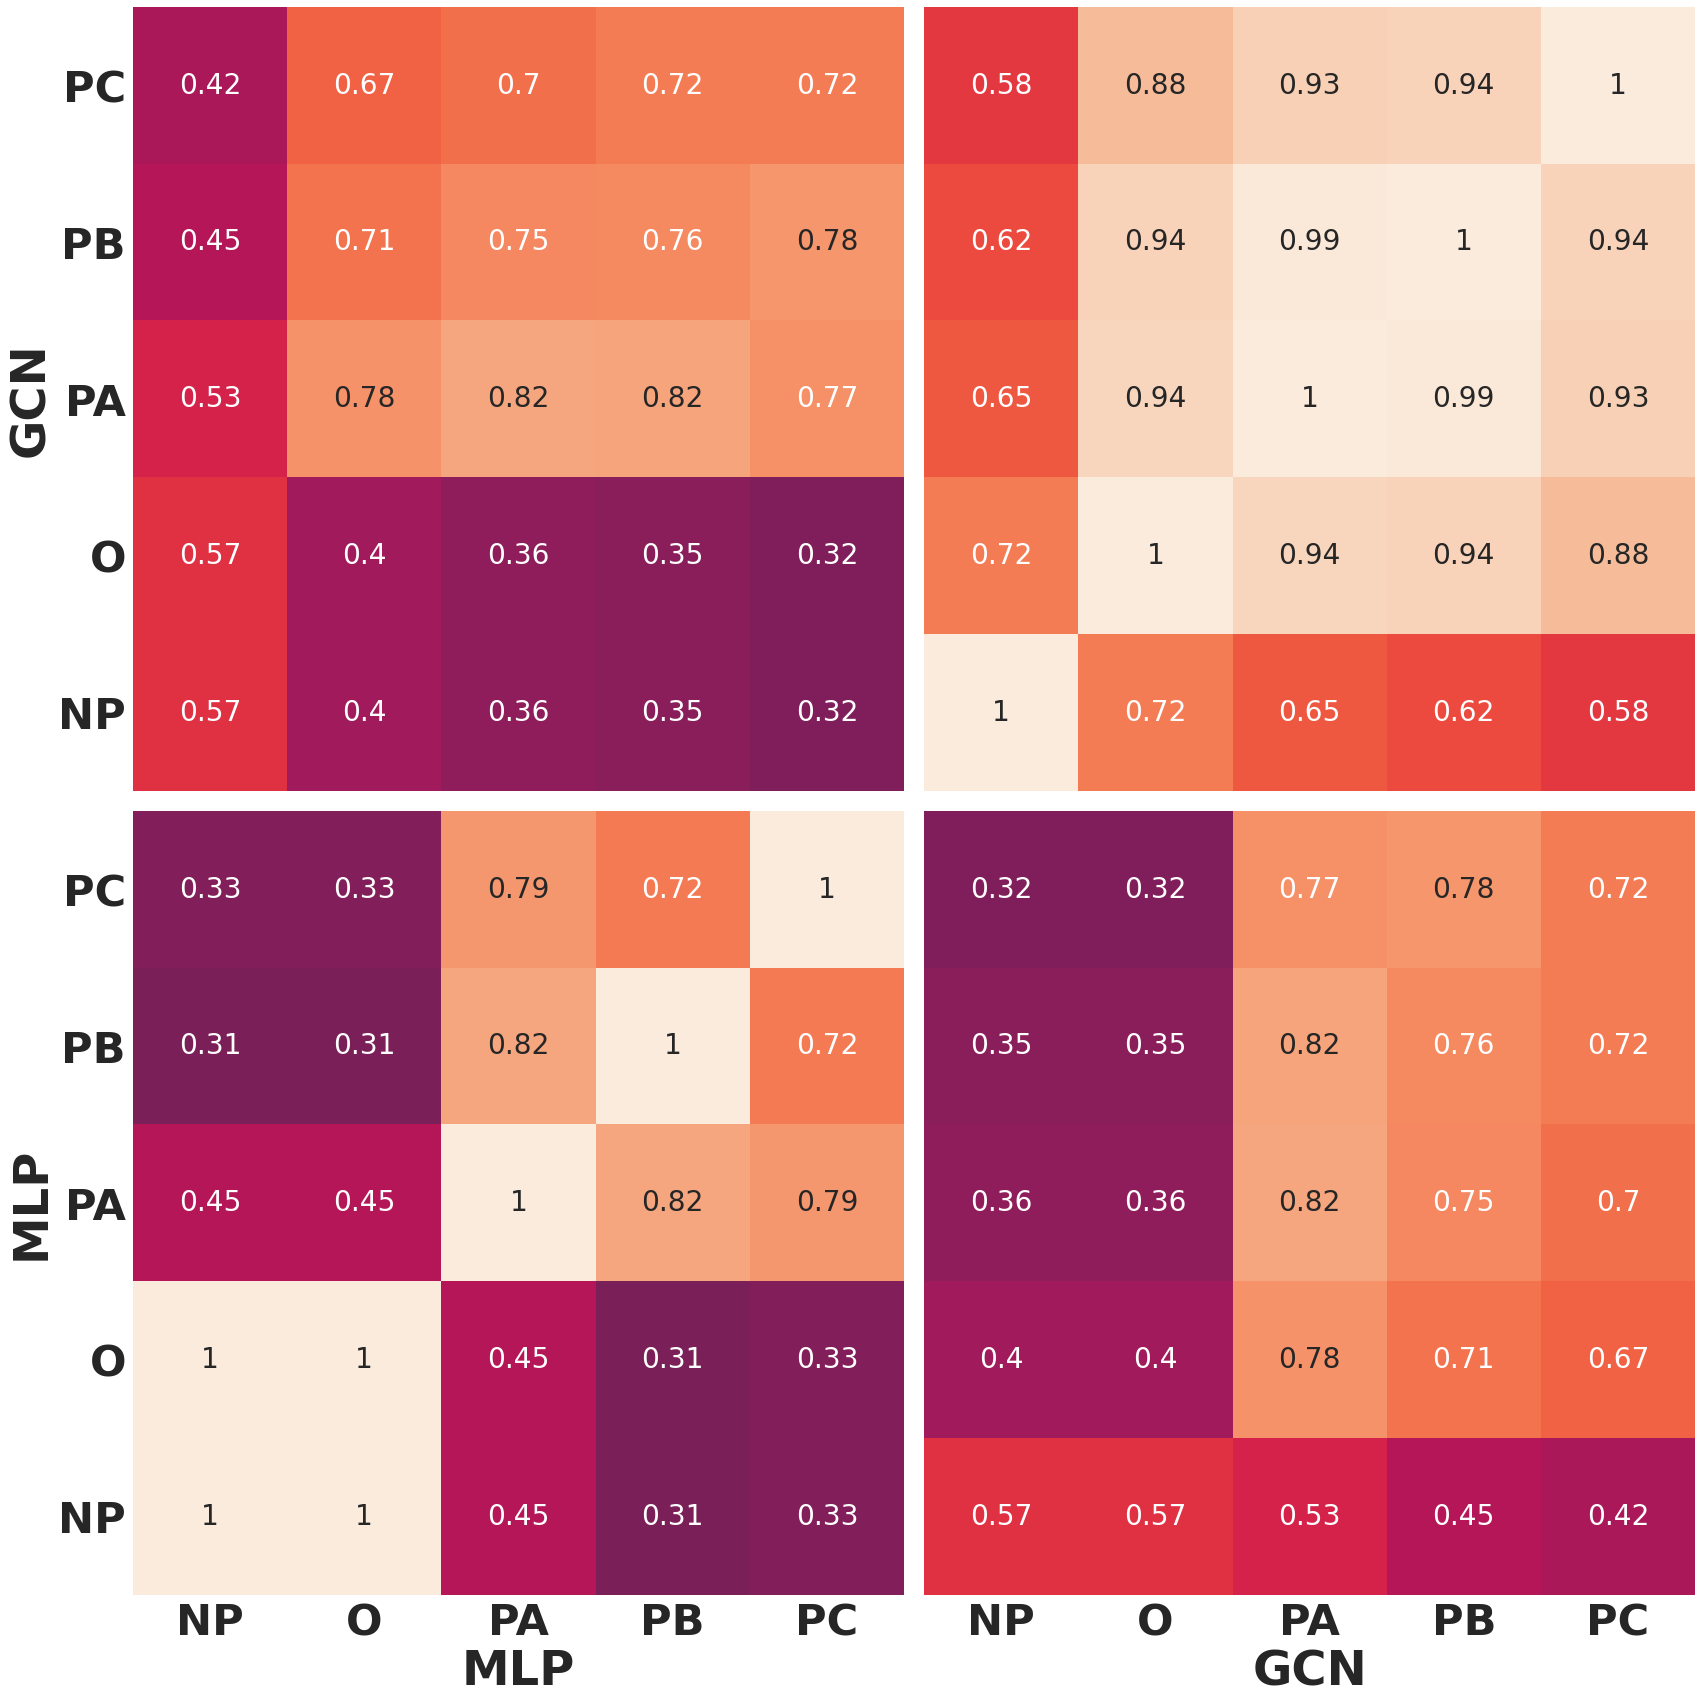

In [20]:
n_models = len(models_dict.keys())
xticklabels = ['NP', 'O', 'PA', 'PB', 'PC']
fig, axs = plt.subplots(n_models, n_models, figsize=(24, 24))
for a, k1 in enumerate(list(cka_values_kernel_dict.keys())[::-1]):
    for b, k2 in enumerate(cka_values_kernel_dict[k1].keys()):
        model_name_1 = k1.upper()
        model_name_2 = k2.upper()
        cor = (a, b)
#         if a < n_models - b - 1:
#             continue
        for k3 in cka_values_kernel_dict[k1][k2].keys():
            values = cka_values_kernel_dict[k1][k2][k3]
            hmap_dict = {}
            n1, n2 = values.shape
            for i in range(n1):
                hmap_dict[str(i + 1)] = {}
                for j in range(n2)[::-1]:
                    hmap_dict[str(i + 1)][str(j + 1)] = values[i][j]
            df = pd.DataFrame.from_dict(hmap_dict)
            if a == 1 and b == 2:
                sns.heatmap(df, vmin=0, vmax=1, annot=True, cbar=False, annot_kws={'size': 28}, ax=axs[cor])
            else:
                sns.heatmap(df, vmin=0, vmax=1, annot=True, cbar=False, annot_kws={'size': 28}, ax=axs[cor])
            # sns.heatmap(df, vmin=0, vmax=1, ax=axs[cor])
            
            if b == 0:
                axs[cor].set_yticklabels(xticklabels[::-1], size=43, fontweight='bold')
                axs[cor].set_ylabel(model_name_1,  size=48, fontweight='bold')
            else:
                empty_string_labels = ['']*len(xticklabels)
                axs[cor].set_yticklabels(empty_string_labels)
            if a == n_models - 1:
                axs[cor].set_xticklabels(xticklabels, size=43, fontweight='bold')
                axs[cor].set_xlabel(model_name_2, size=48, fontweight='bold')
            else:
                empty_string_labels = ['']*len(xticklabels)
                axs[cor].set_xticklabels(empty_string_labels)
            axs[cor].tick_params(axis='y', rotation=0)
            # axs[cor].set_title("CKA kernel ({})".format(k3), size=32)
        # cax = plt.gcf().axes[-1]
        # cax.tick_params(labelsize=32)
fig.tight_layout(pad=2.0)
# plt.savefig(os.path.join(figure_dir, "cka_kernel.png"))
plt.show()

In [14]:
cka_values_kernel_dict = {}
locs = ['np', 'orig', 'a', 'b', 'c']
for k1 in models_dict.keys():
    n1 = len(activations[k1])
    cka_values_kernel_dict[k1] = {}
    for k2 in models_dict.keys():
        n2 = len(activations[k2])
        cka_values_kernel = np.zeros([n1, n2])
        cka_values_kernel_train = np.zeros([n1, n2])
        cka_values_kernel_val = np.zeros([n1, n2])
        cka_values_kernel_test = np.zeros([n1, n2])
        for i, l1 in enumerate(locs):
            for j, l2 in enumerate(locs):
                X = activations[k1][l1]
                Y = activations[k2][l2]
                cka_values_kernel[i][j] = gsim.cka(X, Y, mode='linear')
                cka_values_kernel_train[i][j] = gsim.cka(X[train_nid], Y[train_nid], mode='linear')
                cka_values_kernel_val[i][j] = gsim.cka(X[val_nid], Y[val_nid], mode='linear')
                cka_values_kernel_test[i][j] = gsim.cka(X[test_nid], Y[test_nid], mode='linear')
        cka_values_kernel_dict[k1][k2] = {}
        cka_values_kernel_dict[k1][k2]['all'] = cka_values_kernel 

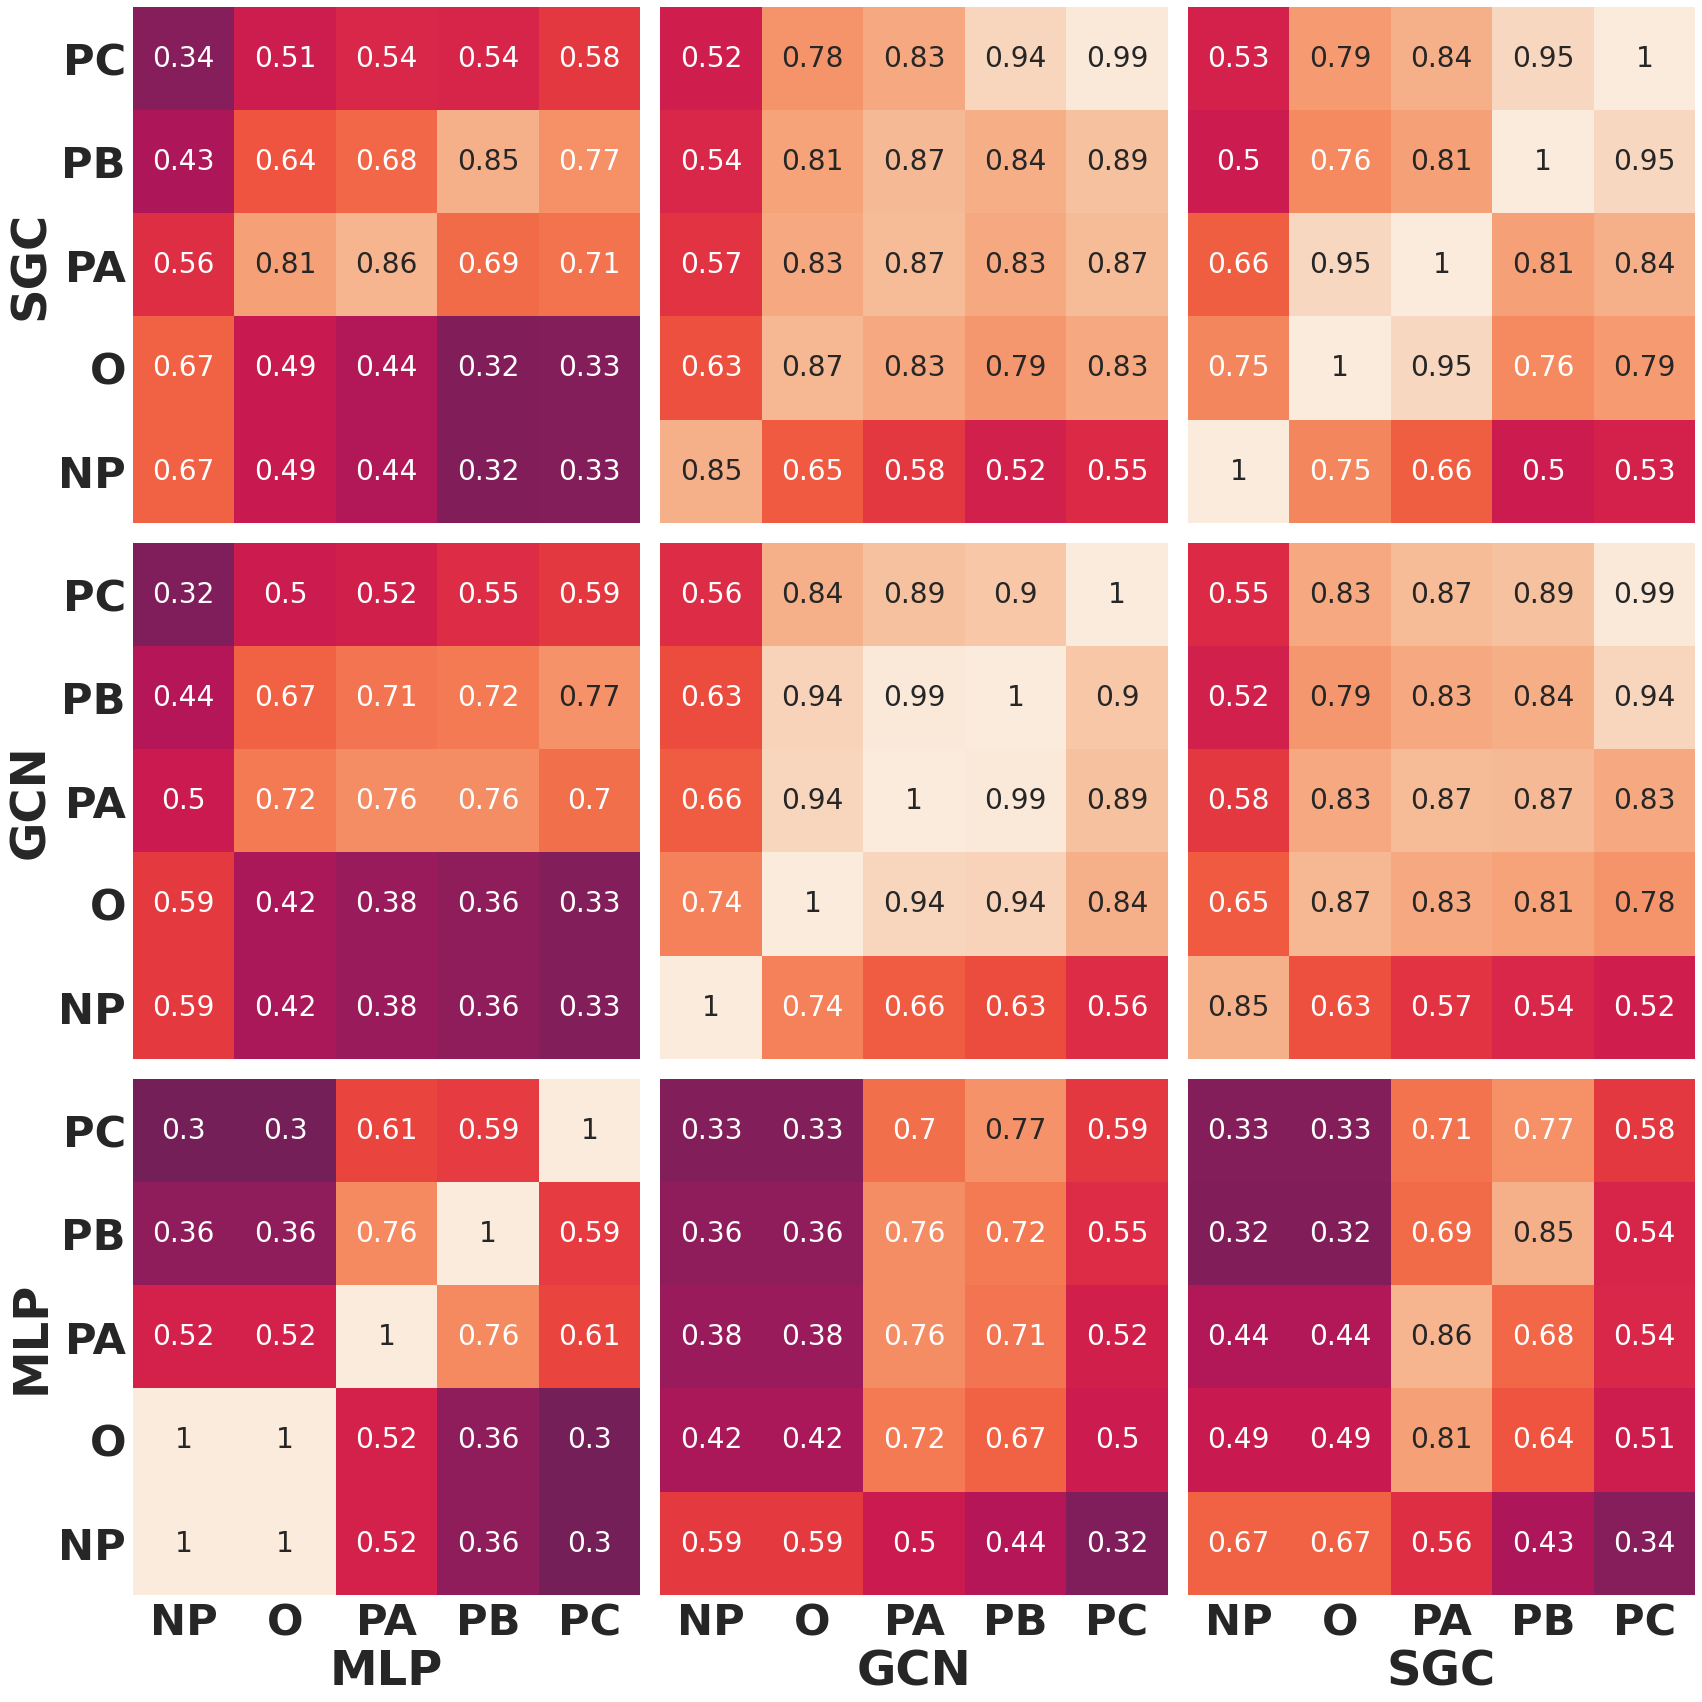

In [15]:
n_models = len(models_dict.keys())
xticklabels = ['NP', 'O', 'PA', 'PB', 'PC']
fig, axs = plt.subplots(n_models, n_models, figsize=(24, 24))
for a, k1 in enumerate(list(cka_values_kernel_dict.keys())[::-1]):
    for b, k2 in enumerate(cka_values_kernel_dict[k1].keys()):
        model_name_1 = k1.upper()
        model_name_2 = k2.upper()
        cor = (a, b)
#         if a < n_models - b - 1:
#             continue
        for k3 in cka_values_kernel_dict[k1][k2].keys():
            values = cka_values_kernel_dict[k1][k2][k3]
            hmap_dict = {}
            n1, n2 = values.shape
            for i in range(n1):
                hmap_dict[str(i + 1)] = {}
                for j in range(n2)[::-1]:
                    hmap_dict[str(i + 1)][str(j + 1)] = values[i][j]
            df = pd.DataFrame.from_dict(hmap_dict)
            if a == 1 and b == 2:
                sns.heatmap(df, vmin=0, vmax=1, annot=True, cbar=False, annot_kws={'size': 28}, ax=axs[cor])
            else:
                sns.heatmap(df, vmin=0, vmax=1, annot=True, cbar=False, annot_kws={'size': 28}, ax=axs[cor])
            # sns.heatmap(df, vmin=0, vmax=1, ax=axs[cor])
            
            if b == 0:
                axs[cor].set_yticklabels(xticklabels[::-1], size=43, fontweight='bold')
                axs[cor].set_ylabel(model_name_1,  size=48, fontweight='bold')
            else:
                empty_string_labels = ['']*len(xticklabels)
                axs[cor].set_yticklabels(empty_string_labels)
            if a == n_models - 1:
                axs[cor].set_xticklabels(xticklabels, size=43, fontweight='bold')
                axs[cor].set_xlabel(model_name_2, size=48, fontweight='bold')
            else:
                empty_string_labels = ['']*len(xticklabels)
                axs[cor].set_xticklabels(empty_string_labels)
            axs[cor].tick_params(axis='y', rotation=0)
            # axs[cor].set_title("CKA kernel ({})".format(k3), size=32)
        # cax = plt.gcf().axes[-1]
        # cax.tick_params(labelsize=32)
fig.tight_layout(pad=2.0)
# plt.savefig(os.path.join(figure_dir, "cka_kernel.png"))
plt.show()